In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
#import the data
creep_df = pd.read_csv('../Data/Ni_superalloys_dataset.csv')
# convert df to float32 for specific libraries requiments
creep_df = creep_df.astype('float32')
# log tranform creep rupture life
Log_Creep_Life = np.log10(creep_df['creep_rupture_life'])
creep_df['Log_Creep_Life'] = Log_Creep_Life
creep_df = creep_df.drop(columns = ['creep_rupture_life'])


# sort the values in ascending creep life
creep_df.sort_values(by=['Log_Creep_Life'], ascending=True, ignore_index=True, inplace=True)

In [3]:
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ni              153 non-null    float32
 1   Al              153 non-null    float32
 2   Co              153 non-null    float32
 3   Cr              153 non-null    float32
 4   Mo              153 non-null    float32
 5   Re              153 non-null    float32
 6   Ru              153 non-null    float32
 7   Ta              153 non-null    float32
 8   W               153 non-null    float32
 9   Ti              153 non-null    float32
 10  Nb              153 non-null    float32
 11  T               153 non-null    float32
 12  stress          153 non-null    float32
 13  Log_Creep_Life  153 non-null    float32
dtypes: float32(14)
memory usage: 8.5 KB


In [4]:
# Extract features and targets
features = creep_df.iloc[:, 0:13]
targets = creep_df.iloc[:, 13]
features

,Ni,Al,Co,Cr,Mo,Re,Ru,Ta,W,Ti,Nb,T,stress
0,61.000000,5.6,9.0,4.3,2.0,2.0,0.0,7.5,8.0,0.0,0.5,1070.0,272.0
1,61.000000,5.6,9.0,4.3,2.0,2.0,0.0,7.5,8.0,0.0,0.5,1100.0,220.0
2,61.000000,5.6,9.0,4.3,2.0,2.0,0.0,7.5,8.0,0.0,0.5,1100.0,225.0
3,61.000000,5.6,9.0,4.3,2.0,2.0,0.0,7.5,8.0,0.0,0.5,1070.0,280.0
4,61.000000,5.6,9.0,4.3,2.0,2.0,0.0,7.5,8.0,0.0,0.5,1100.0,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,61.680000,6.0,9.0,3.5,1.5,4.0,0.0,8.0,6.0,0.2,0.0,1100.0,120.0
149,59.299999,5.8,5.8,2.9,3.9,4.9,6.0,5.6,5.8,0.0,0.0,1000.0,245.0
150,59.799999,5.6,5.6,4.6,2.4,6.4,5.0,5.6,5.0,0.0,0.0,1000.0,245.0
151,59.299999,5.8,5.8,2.9,3.9,4.9,6.0,5.6,5.8,0.0,0.0,1100.0,137.0


In [5]:
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1


Pearson CC: 0.8601520971429131
R2 score: 0.7229547642953882
RMSE: 0.17293450954921816
MAE: 0.12578463954033234
Coverage: 90.32258064516122
Interval Width: 0.5747427916358454
Composite Metric: 1.112396537046501


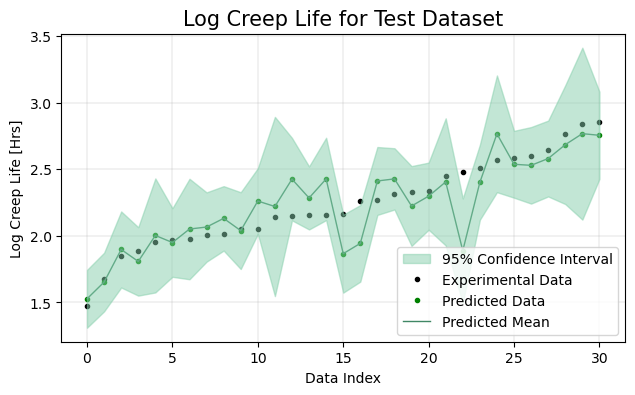

********************
Run # 1 Fold # 2
Pearson CC: 0.9340561759846797
R2 score: 0.8559334160713907
RMSE: 0.19166493113103594
MAE: 0.13944830662901347
Coverage: 83.87096774193543
Interval Width: 0.4738411771958795
Composite Metric: 1.1566352019020738


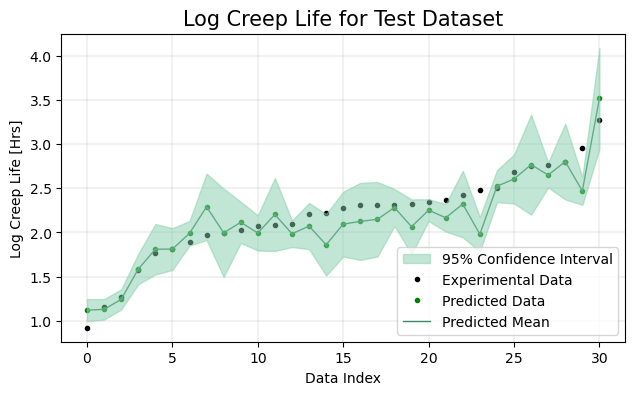

********************
Run # 1 Fold # 3
Pearson CC: 0.9242554181683986
R2 score: 0.8455873869279494
RMSE: 0.17095995136132042
MAE: 0.11965029076770642
Coverage: 96.77419354838705
Interval Width: 0.6429630264330299
Composite Metric: 1.114631298022698


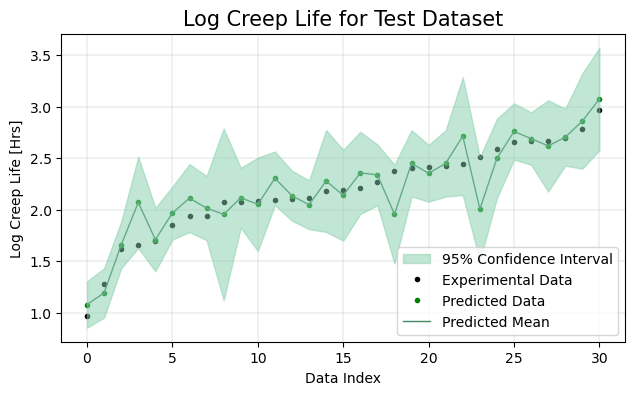

********************
Run # 1 Fold # 4
Pearson CC: 0.8541609755841946
R2 score: 0.716964750025676
RMSE: 0.1955284336481482
MAE: 0.1270929104655602
Coverage: 93.33333333333331
Interval Width: 0.5656681391442646
Composite Metric: 1.141955243189402


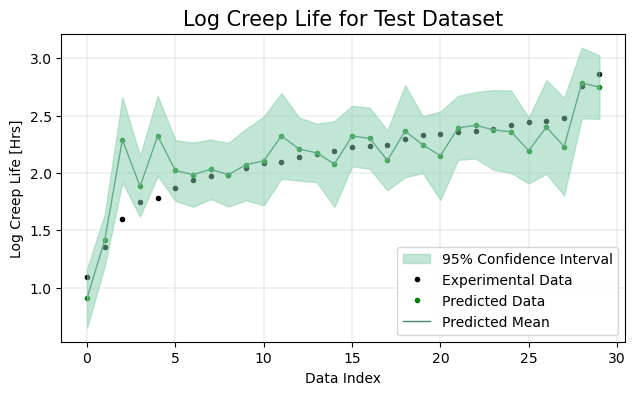

********************
Run # 1 Fold # 5
Pearson CC: 0.9137255773825113
R2 score: 0.8344643203695457
RMSE: 0.1605673639872454
MAE: 0.11613613382371303
Coverage: 96.66666666666664
Interval Width: 0.6185083122827302
Composite Metric: 1.1291982864827221


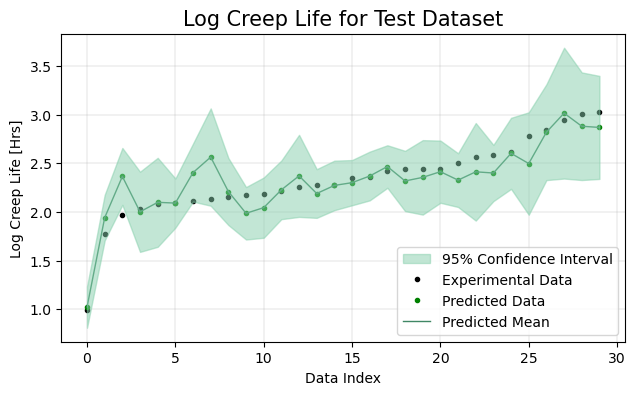

********************


In [6]:
# Evaluate multiple runs of the model
nruns = 1

nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)

            model.fit(X_train, y_train)

            mu_z, std_z = model.predict(X_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            df_test_low = y_pred_test - 2 * y_pred_unc_test
            df_test_median = y_pred_test
            df_test_high = y_pred_test + 2 * y_pred_unc_test

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)


            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'Coverage: {test_coverage[j, i]}')

            
            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.

            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test 
            y_std = y_pred_unc_test
            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            fig.delaxes(ax[1])

            plt.show()

            print(20*'*')

In [7]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.860152,0.722955,0.172935,0.125785,90.322581
1,0.934056,0.855933,0.191665,0.139448,83.870968
2,0.924255,0.845587,0.170960,0.119650,96.774194
3,0.854161,0.716965,0.195528,0.127093,93.333333
4,0.913726,0.834464,0.160567,0.116136,96.666667


In [8]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.89727,0.033432,0.795181,0.061821,0.178331,0.01321,0.125622,0.007987,92.193548,4.797001


In [9]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,90.322581,0.574743,1.112397
1,83.870968,0.473841,1.156635
2,96.774194,0.642963,1.114631
3,93.333333,0.565668,1.141955
4,96.666667,0.618508,1.129198


In [10]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,92.193548,4.797001,0.575145,0.058021,1.130963,0.0167
